In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Fri Dec 10 22:21:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cd /content/drive/MyDrive/Research_copy/knnw/vae/NVAE

/content/drive/MyDrive/Research_copy/knnw/vae/NVAE


In [ ]:
!pip install -r requirements.txt

In [ ]:
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import torchvision
from torch.utils.data import Dataset, DataLoader


# !cd /content/drive/MyDrive/Research_copy/knnw/vae/NVAE
from model import AutoEncoder
import utils

import os 
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '6020'

torch.distributed.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=1)

from model import AutoEncoder
import utils


class args:

    def __init__(self):

        self.ada_groups=False
        self.arch_instance='res_mbconv'
        self.batch_size=32
        self.cont_training=False
        self.data='DATA_DIR'
        self.dataset='cifar10'
        self.epochs=400
        self.fast_adamax=True
        self.global_rank=0
        self.kl_anneal_portion=0.3
        self.kl_const_coeff=0.0001
        self.kl_const_portion=0.0001
        self.learning_rate=0.01
        self.learning_rate_min=0.0001
        self.local_rank=0
        self.master_address='127.0.0.1'
        self.min_groups_per_scale=1
        self.node_rank=0
        self.num_cell_per_cond_dec=2
        self.num_cell_per_cond_enc=2
        self.num_channels_dec=128
        self.num_channels_enc=128
        self.num_groups_per_scale=30
        self.num_latent_per_group=20
        self.num_latent_scales=1
        self.num_mixture_dec=10
        self.num_nf=1
        self.num_postprocess_blocks=1
        self.num_postprocess_cells=2
        self.num_preprocess_blocks=1
        self.num_preprocess_cells=2
        self.num_proc_node=1
        self.num_process_per_node=8
        self.num_x_bits=8
        self.res_dist=True
        self.root='PATH_TO_CHECKPOINT_DIR'
        self.save='UNIQUE_EXPR_ID'
        self.seed=1
        self.use_se=False
        self.warmup_epochs=5
        self.weight_decay=0.0003
        self.distributed = torch.distributed

args = args()
writer = None
arch_instance = utils.get_arch_cells(args.arch_instance)

model = AutoEncoder(args, writer, arch_instance)
model.cuda()


In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/NVAE Checkpoints Github/cifar10/quantitative/checkpoint.pt')
checkpoint = torch.load('/content/drive/MyDrive/Research/knnw/vae/NVAE/eval-knnw_1_attempt/checkpoint.pt')
# checkpoint = torch.load('/content/drive/MyDrive/Research/knnw/vae/NVAE/eval-knnw_attempt_2/checkpoint.pt')
# checkpoint = torch.load('/content/drive/MyDrive/Research_copy/knnw/vae/NVAE/eval-knnw_addon_train2/checkpoint.pt2')



args = checkpoint['args']


if not hasattr(args, 'ada_groups'):
    args.ada_groups = False

if not hasattr(args, 'min_groups_per_scale'):
    args.min_groups_per_scale = 1

if not hasattr(args, 'num_mixture_dec'):
    args.num_mixture_dec = 10

arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, None, arch_instance)

model.load_state_dict(checkpoint['state_dict'], strict=False)
model = model.cuda()
model.eval()

In [ ]:
del checkpoint

#qscale31_tar file

In [ ]:
cd /content

/content


In [ ]:
!gdown --id 1iQu3EzT1VHUZnCyBvYXIGom2_V0Z79wg &     #Unique Label Data

Downloading...
From: https://drive.google.com/uc?id=1iQu3EzT1VHUZnCyBvYXIGom2_V0Z79wg
To: /content/knnw_720p_qscale31_unique.tar.gz
100% 2.08G/2.08G [00:19<00:00, 109MB/s] 


In [ ]:
!gdown --id 1ZqUAj6yZItzFG9b4OJdnEEwSumUMEuVO

209294

In [ ]:
!tar -xzvf "/content/knnw_720p_qscale31_unique.tar.gz" -C "/content"     #Unzip Unique Label Data

In [ ]:
!mkdir val_data

In [ ]:
!mv qscale31_unique val_data/.

In [ ]:
batch_size_val = 16

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
class MyImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index]#return image path


val_dataset = MyImageFolder(root='val_data', transform=transforms)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, 
                                             shuffle=False, num_workers=2)


start_idx = 87435

end_idx = 21858

last_20_idx = list(range(start_idx, len(val_dataset)))
# last_20_idx = list(range(0, end_idx))
last_20_valset = torch.utils.data.Subset(val_dataset, last_20_idx)
val_20_dataloader = torch.utils.data.DataLoader(last_20_valset, batch_size=batch_size_val, 
                                             shuffle=False, num_workers=2)

total_ip = len(val_dataloader.dataset)

In [ ]:
import gc
mu_list_1 = []
log_sig_list_1 = []
frames_list_1 = []
for batch_num, data in tqdm(enumerate(val_20_dataloader)):
    
    # x, y, samples_fname
    (x,y),(samples_fname,_) = data
    x = x.cuda()
    mu, log_sig = model(x)
    for mu_i, sig_i, frame_i in zip(mu.cpu().detach().numpy(), log_sig.cpu().detach().numpy(), samples_fname):
        mu_i = np.tanh(mu_i/5)*5
        sig_i = np.tanh(sig_i/5)*5
        
        # print(mu_i.shape)
        # mu_list_1.append(mu_i.reshape(5120,1))
        mu_list_1.append(mu_i.reshape(5120,1))
        log_sig_list_1.append((np.exp(sig_i)+ 1e-2).reshape(5120,1))
        frames_list_1.append(frame_i)
    del x, mu, log_sig
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def KL_Div(mu0, mu1, var0, var1):
    KLD = 0.5 * ((var0 / var1) + (mu1 - mu0) * (1 / var1) * (mu1 - mu0) - 1 + np.log(var1 / var0))

    return KLD

def KL_Div_Loss(mu0_vector, mu1_vector, var0_vector, var1_vector):
    total_KLD = 0

    for (mu0, mu1, var0, var1) in zip(mu0_vector, mu1_vector, var0_vector, var1_vector):
        total_KLD += KL_Div(mu0, mu1, var0, var1)

    return total_KLD

In [ ]:
kld_list = [0]
for i in tqdm(range(len(mu_list_1) - 1)):
  kld = KL_Div_Loss(mu_list_1[i], mu_list_1[i+1], log_sig_list_1[i], log_sig_list_1[i+1])
  kld_list.append(kld[0])

In [ ]:
idx = np.array(kld_list).argsort()

In [ ]:
!gdown --id 1Om_tsDVyFNAEaCg0l87HNABbErSBbkBM

Downloading...
From: https://drive.google.com/uc?id=1Om_tsDVyFNAEaCg0l87HNABbErSBbkBM
To: /content/knnw_labeles_for_vae_team.csv
100% 4.59M/4.59M [00:00<00:00, 71.7MB/s]


In [ ]:
all_labels = pd.read_csv('/content/knnw_labeles_for_vae_team.csv')

In [ ]:
all_labels

,frame1,frame2
0,frame_000001.jpg,frame_000035.jpg
1,frame_000035.jpg,frame_000037.jpg
2,frame_000037.jpg,frame_000038.jpg
3,frame_000038.jpg,frame_000039.jpg
4,frame_000039.jpg,frame_000040.jpg
...,...,...
109288,frame_191796.jpg,frame_191811.jpg
109289,frame_191811.jpg,frame_191842.jpg
109290,frame_191842.jpg,frame_191857.jpg
109291,frame_191857.jpg,frame_191872.jpg


In [ ]:
start_idx = 87435
# last_20p = all_labels[:21858]
last_20p = all_labels[start_idx:]
last_20_changes = last_20p[last_20p['shot_change'] == 1]

1692 sh

In [ ]:
only_changes = all_labels[all_labels['shot_change'] == 1]

In [ ]:
import os
correct_pred = 0
for id in predicted:
    frame_name = frames_list_1[id]
    if(len(last_20_changes[last_20_changes['frame2']== os.path.basename(frame_name)]) > 0):
        correct_pred += 1

In [ ]:
len(last_20_changes)

187

In [ ]:
print("Correct predictions = ", correct_pred)
print("Accuracy = ", correct_pred/len(last_20_changes)*100)

156
83.42245989304813


#t-SNE Plot

In [ ]:
!ls -lrth

total 4.0K
drwxr-xr-x 1 root root 4.0K Nov 18 14:36 sample_data


In [ ]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
x_vec = np.concatenate((log_sig_list_1, mu_list_1), axis=1)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(x_vec.squeeze())
X_embedded.shape

(21859, 2)

In [ ]:
df = pd.DataFrame()
df_subset = pd.DataFrame()

df_subset['tsne-2d-one'] = X_embedded[:100,0]
df_subset['tsne-2d-two'] = X_embedded[:100,1]

df['tsne-2d-one'] = X_embedded[:-1,0]
df['tsne-2d-two'] = X_embedded[:-1,1]

In [ ]:
labels_y = np.array(last_20p['shot_change'])

In [ ]:
# np.array(last_20_changes[['frame1', 'frame2']])
# last_20_changes
labels = []
no_of_changes = 0
temp = np.array(last_20p[['shot_change']])
change_status = temp.flatten()
prev_val = change_status[0]
for val in change_status:
  if val == 1:
    no_of_changes += 1
    prev_val = val
  labels.append(no_of_changes)

In [ ]:
df['labels'] =  labels

#CIFAR BASELINE


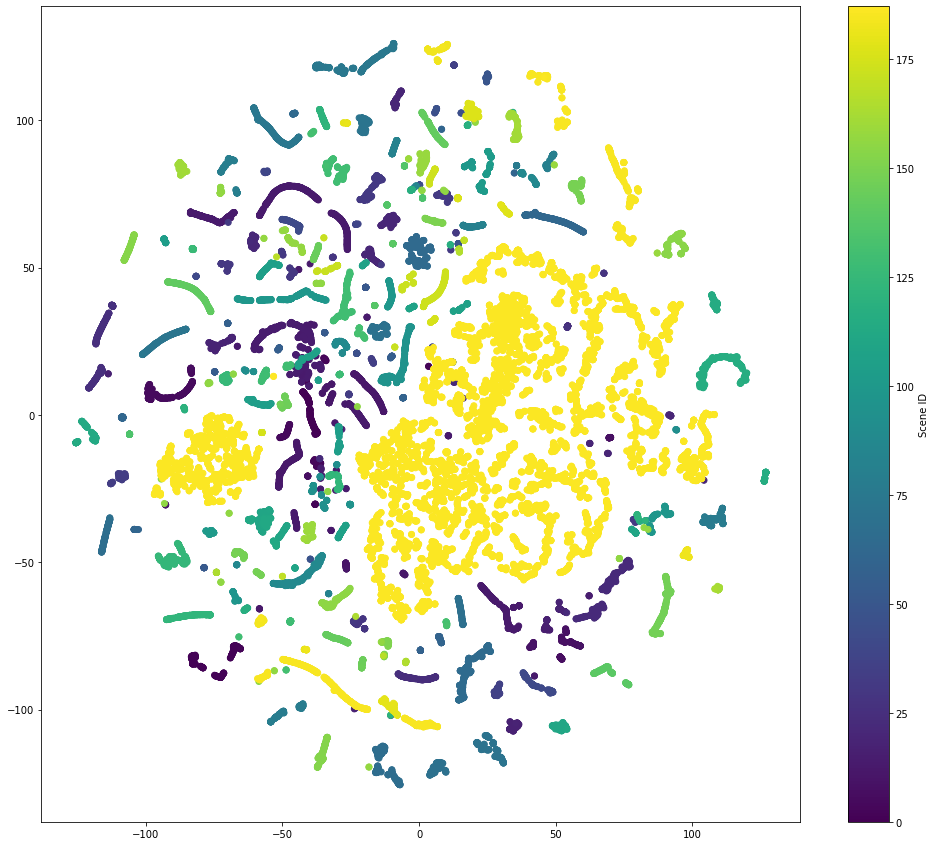

In [ ]:
fig = plt.figure(1, (17., 15.))
plt.scatter(X_embedded[:-1,0], X_embedded[:-1,1], alpha=1.0, c=labels, cmap="viridis")
cb = plt.colorbar()
cb.set_label('Scene ID')

TypeError: ignored

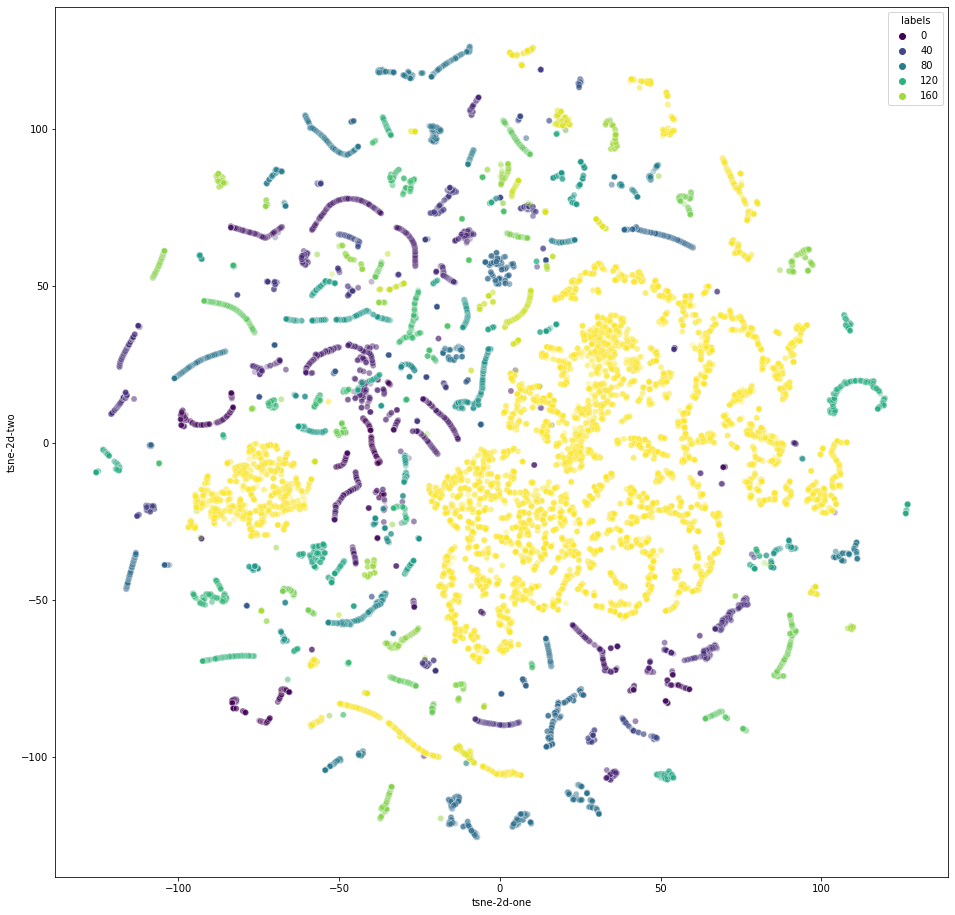

In [ ]:
a = plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue=labels_y,
    hue='labels',
    palette=sns.color_palette("viridis", as_cmap=True),
    # palette = 'deep',
    data=df,
    # legend="full",
    alpha=0.3
)

cb = plt.colorbar()
cb.set_label('Scene ID')

#Scratch 128

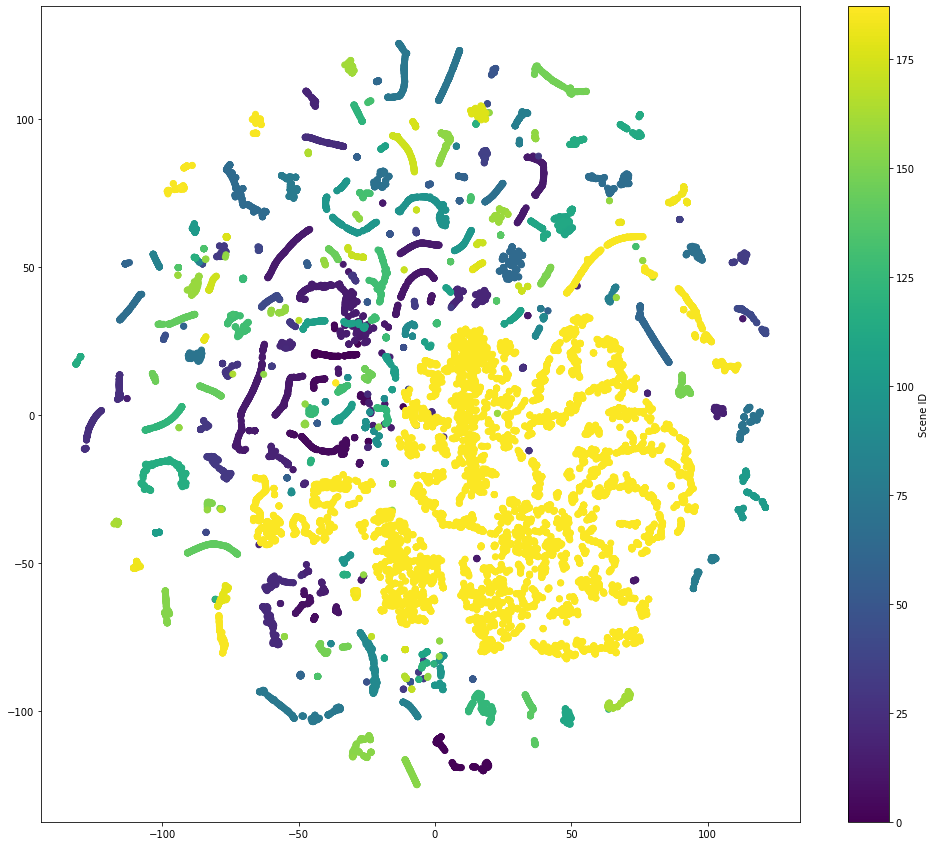

In [ ]:
fig = plt.figure(1, (17., 15.))
plt.scatter(X_embedded[:-1,0], X_embedded[:-1,1], alpha=1.0, c=labels, cmap="viridis")
cb = plt.colorbar()
cb.set_label('Scene ID')

In [ ]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue=labels_y,
    hue='labels',
    palette=sns.color_palette("viridis", as_cmap=True),
    # palette = 'deep',
    data=df,
    # legend="full",
    alpha=0.3
)

#Scratch 32

In [ ]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue=labels_y,
    hue='labels',
    palette=sns.color_palette("viridis", as_cmap=True),
    # palette = 'deep',
    data=df,
    # legend="full",
    alpha=0.3
)

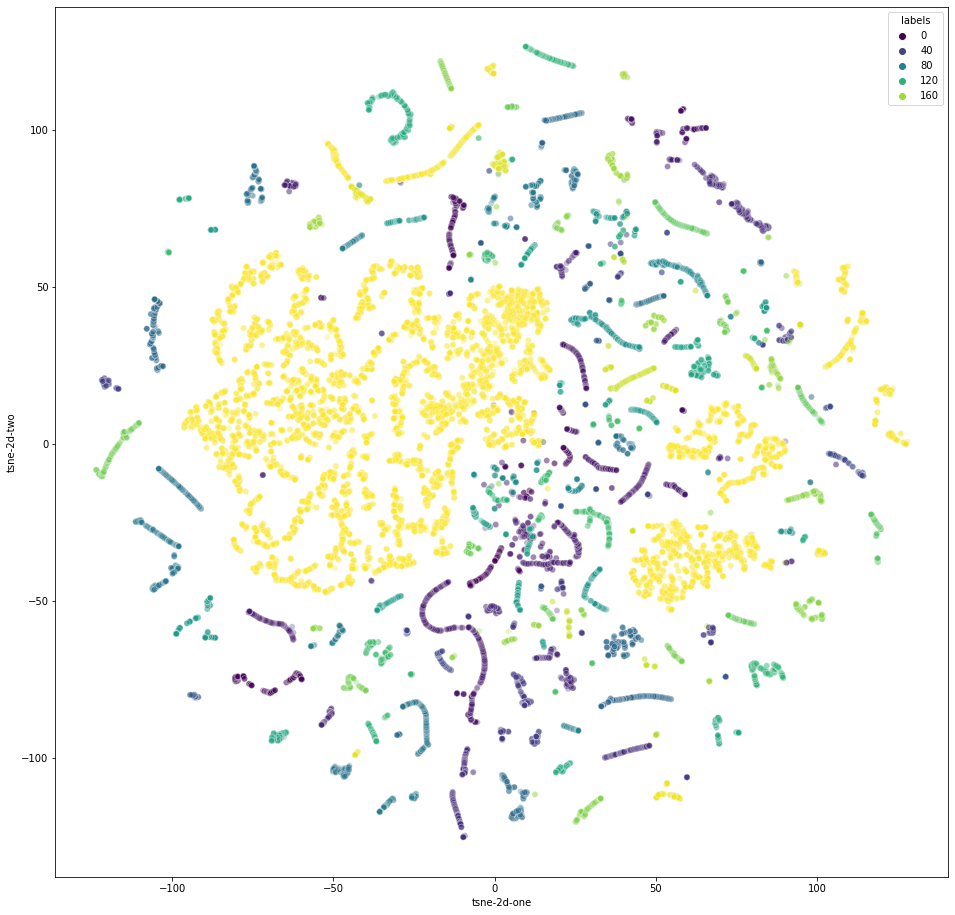

In [ ]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue=labels_y,
    hue='labels',
    palette=sns.color_palette("viridis", as_cmap=True),
    # palette = 'deep',
    data=df,
    
    # legend="full",
    alpha=0.3
)
cb = plt.colorbar()
cb.set_label('Scene ID')

In [ ]:
labels_y = np.array(last_20p['shot_change'])

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
plot_scatter(, labels_y, mode='TSNE', fname='tsne2.png')